In [4]:
# # Step 1: Install the package
# !pip install dataprep
# !pip install scikit-survival
# !pip install lifelines
# !pip install shap

In [5]:
# Step 2: Load packages

# Packages to load and preprocess data
import numpy as np
import pandas as pd

# Packages to visualise and explore data
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
# from dataprep.eda import plot, create_report
# from dataprep.eda import plot, create_report, plot_missing, plot_correlation

# Packages to prepare data for ML  
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Packages for survival analysis
from lifelines import CoxPHFitter 
from lifelines.utils import k_fold_cross_validation
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter 
from lifelines.plotting import add_at_risk_counts

# Packages for ML in survival analysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# Package to interpret data
import shap


# Ignore the warnings notifications
import warnings
warnings.filterwarnings("ignore")


In [6]:
# Step 3: Load data
file1 = pd.read_csv('Data/data_clinical_patient.csv')
file2 = pd.read_csv('Data/data_clinical_sample.csv')

In [7]:
# 3.1 Merge clinical data
data = pd.merge(file1,file2, how="inner", on=["PATIENT_ID"])

In [8]:
# Have a quick look on data
data.info()

# Data information
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 0 to 2508
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PATIENT_ID                     2509 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE  2243 non-null   float64
 2   NPI                            2287 non-null   float64
 3   CELLULARITY                    1917 non-null   object 
 4   CHEMOTHERAPY                   1980 non-null   object 
 5   COHORT                         2498 non-null   float64
 6   ER_IHC                         2426 non-null   object 
 7   HER2_SNP6                      1980 non-null   object 
 8   HORMONE_THERAPY                1980 non-null   object 
 9   INFERRED_MENOPAUSAL_STATE      1980 non-null   object 
 10  SEX                            2509 non-null   object 
 11  INTCLUST                       1980 non-null   object 
 12  AGE_AT_DIAGNOSIS               2498 non-null   f

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,...,CANCER_TYPE_DETAILED,ER_STATUS,HER2_STATUS,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS
0,MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,...,Breast Invasive Ductal Carcinoma,Positive,Negative,3.0,IDC,Negative,Primary,22.0,2.0,0.000000
1,MB-0002,0.0,4.020,High,NO,1.0,Positve,NEUTRAL,YES,Pre,...,Breast Invasive Ductal Carcinoma,Positive,Negative,3.0,IDC,Positive,Primary,10.0,1.0,2.615035
2,MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,...,Breast Invasive Ductal Carcinoma,Positive,Negative,2.0,IDC,Positive,Primary,15.0,2.0,2.615035
3,MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,...,Breast Mixed Ductal and Lobular Carcinoma,Positive,Negative,2.0,MDLC,Positive,Primary,25.0,2.0,1.307518
4,MB-0008,8.0,6.080,High,YES,1.0,Positve,NEUTRAL,YES,Post,...,Breast Mixed Ductal and Lobular Carcinoma,Positive,Negative,3.0,MDLC,Positive,Primary,40.0,2.0,2.615035


In [9]:
# Step 4: Preprocess data & Explore data

# 4.1 Check duplicate values
print('The number of duplicate values in data:',
         data.duplicated().sum())

# 4.2 Drop unused cols: Based on data.info(), we will drop some unused cols and null cols

drop_list = ['VITAL_STATUS', 'SAMPLE_ID', 'SEX', 'SAMPLE_TYPE',
            'RFS_STATUS', 'RFS_MONTHS']
data = data.drop(drop_list, axis=1)

# We check the number of patients by cancer type
print('\nGroup Patients by',data.groupby('CANCER_TYPE')['PATIENT_ID'].count())

# There are only three patients with Breast Sarcoma
# So we will filter those patients with Breast Cancer type
data = data[data['CANCER_TYPE'] == 'Breast Cancer']

# Delete Cancer type columns as this column reports the same
# value for all the samples, and it does not bring any useful
# information for the following steps of the analysis
data = data.drop(['CANCER_TYPE'], axis=1)
print('\nAfter the preprocessing, the shape of data is:', data.shape)


The number of duplicate values in data: 0

Group Patients by CANCER_TYPE
Breast Cancer     2506
Breast Sarcoma       3
Name: PATIENT_ID, dtype: int64

After the preprocessing, the shape of data is: (2506, 29)


In [10]:
# 4.3: Understand data
# Save to report as html file
# create_report(data).save('Plot\EDA_clinical_report')

# # Optional to explore parts of the report
# plot_missing(data).save('Plot\missing_values.html')
# plot(data).save('Plot\data.html')

In [11]:
# Step 4.4: Deal with missing values

# There is no columns more than 50% missing value
cols_mv_50 = data.columns[data.isnull().mean()>0.5]
print('Number of columns having more 50% missing data:', len(cols_mv_50))

# Remove row with more than 50% missing
percent = 50
min_count =  int(((100-percent)/100)*data.shape[1] + 1)
data = data.dropna(axis=0, thresh=min_count)
print('After removing rows with more than 50% missing values:', data.shape)

# Print columns name having blanks
cols_missvalue = data.columns[data.isnull().sum()>0]
print('List columns having missing data:', cols_missvalue)

cat_var = ['LYMPH_NODES_EXAMINED_POSITIVE', 'CELLULARITY', 'ER_IHC',
            'THREEGENE', 'LATERALITY', 'HISTOLOGICAL_SUBTYPE',
            'BREAST_SURGERY', 'GRADE', 'TUMOR_STAGE']
num_var = ['TUMOR_SIZE']

# Replace missing values with most frequent values
data[cat_var] = data[cat_var].fillna(data[cat_var].mode().iloc[0])

# Replace missing values with average values
data[num_var] = data[num_var].fillna(data[num_var].mean())

# Check missing values again
print('After preprocessing, missing value number:', data.isna().sum().sum())


Number of columns having more 50% missing data: 0
After removing rows with more than 50% missing values: (1977, 29)
List columns having missing data: Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'CELLULARITY', 'ER_IHC', 'THREEGENE',
       'LATERALITY', 'HISTOLOGICAL_SUBTYPE', 'BREAST_SURGERY', 'GRADE',
       'TUMOR_SIZE', 'TUMOR_STAGE'],
      dtype='object')
After preprocessing, missing value number: 0


In [12]:
# Step 4.5: Exploring data
# plot(data.iloc[:,1:]).save('Plot\preprocessed_data.html')

In [13]:
# 4.6 Encode Categorical data

# Encode OS status to dummy
data['OS_STATUS'] = np.where(data['OS_STATUS'] == '1:DECEASED', 1, 0)

# Encode other categorical variables
other_var = ['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI','AGE_AT_DIAGNOSIS', 'COHORT', 'GRADE',
            'TUMOR_SIZE', 'TUMOR_STAGE', 'TMB_NONSYNONYMOUS','OS_MONTHS', 'OS_STATUS','PATIENT_ID']
df_encode = data.drop(other_var, axis=1)

# Some variables are not in order, so we have to specify the variables and their corresponding order 
modified_list =['CELLULARITY', 'HER2_SNP6', 'INFERRED_MENOPAUSAL_STATE', 'INTCLUST', 'THREEGENE']
keep_list = df_encode.columns[~df_encode.columns.isin(modified_list)]
cel_cat = ['Low', 'Moderate', 'High']
her2_cat = ['UNDEF','LOSS', 'NEUTRAL', 'GAIN']
inf_cat = ['Pre', 'Post']
intclust_cat = ['1', '2', '3', '4ER+', '4ER-', '5', '6', '7', '8', '9', '10']
three_gene_cat = ['ER-/HER2-', 'HER2+', 'ER+/HER2- Low Prolif', 'ER+/HER2- High Prolif']

In [14]:
# Encode the predefined order variables 
enc = OrdinalEncoder(categories=[cel_cat, her2_cat, inf_cat, intclust_cat, three_gene_cat]).fit(df_encode[modified_list])
encoder = enc.transform(df_encode[modified_list])
df_encode_new = pd.DataFrame(encoder, columns=modified_list)

# Encode the other variables 
enc1 = OrdinalEncoder().fit(df_encode[keep_list])
encoder1 = enc1.transform(df_encode[keep_list])
df_encode_new1 = pd.DataFrame(encoder1, columns=keep_list)

# Merge encode data and original data
df =pd.concat([df_encode_new, df_encode_new1, data[other_var].reset_index(drop=True)], axis=1)
print(df.shape)


(1977, 29)


In [15]:
# To check the encoded categories
for i in range(len(modified_list)):
    print(modified_list[i], enc.categories_[i])
for i in range(len(keep_list)):
    print(keep_list[i], enc1.categories_[i])

CELLULARITY ['Low' 'Moderate' 'High']
HER2_SNP6 ['UNDEF' 'LOSS' 'NEUTRAL' 'GAIN']
INFERRED_MENOPAUSAL_STATE ['Pre' 'Post']
INTCLUST ['1' '2' '3' '4ER+' '4ER-' '5' '6' '7' '8' '9' '10']
THREEGENE ['ER-/HER2-' 'HER2+' 'ER+/HER2- Low Prolif' 'ER+/HER2- High Prolif']
CHEMOTHERAPY ['NO' 'YES']
ER_IHC ['Negative' 'Positve']
HORMONE_THERAPY ['NO' 'YES']
CLAUDIN_SUBTYPE ['Basal' 'Her2' 'LumA' 'LumB' 'NC' 'Normal' 'claudin-low']
LATERALITY ['Left' 'Right']
RADIO_THERAPY ['NO' 'YES']
HISTOLOGICAL_SUBTYPE ['Ductal/NST' 'Lobular' 'Medullary' 'Metaplastic' 'Mixed' 'Mucinous'
 'Other' 'Tubular/ cribriform']
BREAST_SURGERY ['BREAST CONSERVING' 'MASTECTOMY']
CANCER_TYPE_DETAILED ['Breast' 'Breast Invasive Ductal Carcinoma'
 'Breast Invasive Lobular Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma' 'Invasive Breast Carcinoma'
 'Metaplastic Breast Cancer']
ER_STATUS ['Negative' 'Positive']
HER2_STATUS ['Negative' 'Positive']
ONCOTREE_CODE ['BRCA' 'BREAST

In [16]:
# Save preprocess data to csv to merge to gene data
df.to_csv('Data\clinical.csv', index=False)

In [17]:
# Drop Patient ID column as this is not relevant for the analysis
df = df.drop(['PATIENT_ID'], axis=1)

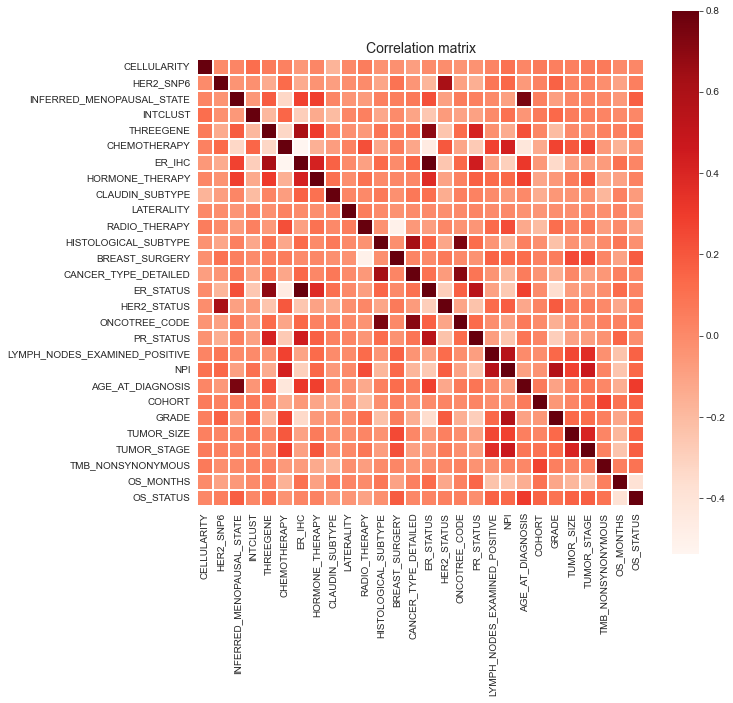

In [18]:
# 4.7 Correlation analysis
colormap = plt.cm.Reds
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),linewidths=0.1,vmax=0.8, 
            square=True, cmap = colormap, linecolor='white')
plt.title('Correlation matrix', fontsize=14)
# plt.savefig('Plot\Correlation_clinical.pdf',bbox_inches='tight')
plt.show()   

42.2% of records are censored


Text(0, 0.5, 'Frequency')

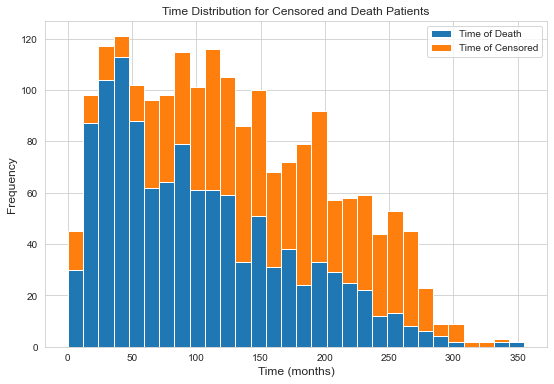

In [19]:
# 4.7 Time Distribution of Death and Censor
num_censored = df.shape[0] - df["OS_STATUS"].sum()
print("%.1f%% of records are censored" % (num_censored/df.shape[0]*100))

plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((df.query('OS_STATUS == 1')['OS_MONTHS'],
                               df.query('OS_STATUS == 0')['OS_MONTHS']),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censored"])
plt.title("Time Distribution for Censored and Death Patients")
plt.xlabel('Time (months)',fontsize='large')
plt.ylabel('Frequency',fontsize='large')
# plt.savefig('Plot\Time_clinical.pdf')  

In [20]:
print("After preprocessing, the shape of dataset", df.shape)

After preprocessing, the shape of dataset (1977, 28)


In [21]:
# Step 5: Cox survival analysis
# 5.1: Normalise data
ss = MinMaxScaler()
df_norm = df.drop(['OS_STATUS', 'OS_MONTHS'], axis = 1)
df_norm = pd.DataFrame(ss.fit_transform(df_norm), columns=df_norm.columns)
df_norm['OS_STATUS'] = df['OS_STATUS']
df_norm['OS_MONTHS'] = df['OS_MONTHS']


<AxesSubplot:title={'center':'Cox Proportional Hazards Model for Clinical data'}, xlabel='log(HR) (95% CI)'>

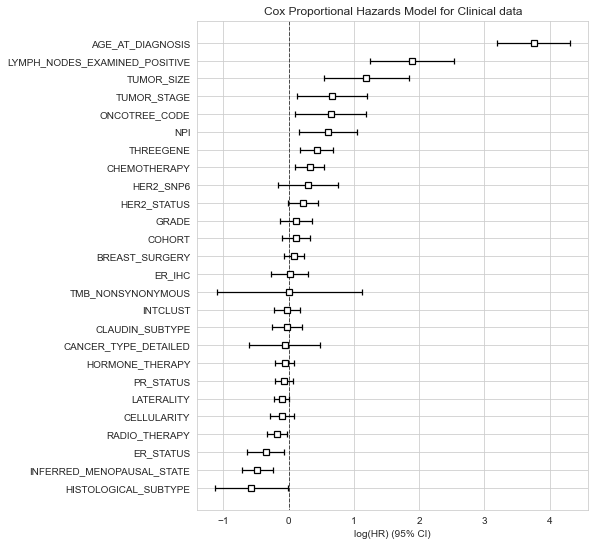

In [22]:
# 5.2: Build model 
# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_norm, duration_col='OS_MONTHS', event_col='OS_STATUS')

# Plot
plt.figure(figsize=(7, 9))
plt.title('Cox Proportional Hazards Model for Clinical data')
cph.plot()
# plt.savefig('Plot\CPH_clinical.png',bbox_inches='tight')  

In [23]:
# Report
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 1977 total observations, 834 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 1977
number of events observed = 1143
   partial log-likelihood = -7603.988
         time fit was run = 2022-02-17 22:44:48 UTC

---
                                coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%      z       p
covariate                                                                                               
CELLULARITY                   -0.107      0.899                0.749                1.079 -1.147   0.251
HER2_SNP6                      0.298      1.347                0.853                2.129  1.277   0.201
INFERRED_MENOPAUSAL_STATE     -0.481      0.618                0.488                0.783 -3.999 <0.0005
INTCLUST                      -0.027      0.973                0.794                1.193 -0.264   0.792
THREEGENE                      0.428      1.535                1.189                1.981  3.286   0.001
CHEMOTHERAPY                   0.324      1.383                1.106                1.728  2.845   0.004
ER_IHC                         0.014      1.014                0.766                1.343  0.099   0.921
HORMONE_THERAPY               -0.061      0.940                0.810                1.091 -0.809   0.418
CLAUDIN_SUBTYPE               -0.029      0.971                0.771                1.224 -0.246   0.806
LATERALITY                    -0.106      0.899                0.799                1.012 -1.765   0.078
RADIO_THERAPY                 -0.179      0.836                0.716                0.975 -2.280   0.023
HISTOLOGICAL_SUBTYPE          -0.571      0.565                0.324                0.984 -2.015   0.044
BREAST_SURGERY                 0.087      1.091                0.935                1.272  1.103   0.270
CANCER_TYPE_DETAILED          -0.060      0.942                0.547                1.624 -0.215   0.830
ER_STATUS                     -0.355      0.701                0.527                0.933 -2.432   0.015
HER2_STATUS                    0.216      1.241                0.983                1.565  1.819   0.069
ONCOTREE_CODE                  0.641      1.898                1.099                3.276  2.300   0.021
PR_STATUS                     -0.071      0.932                0.809                1.073 -0.983   0.326
LYMPH_NODES_EXAMINED_POSITIVE  1.888      6.607                3.451               12.648  5.699 <0.0005
NPI                            0.597      1.817                1.162                2.841  2.618   0.009
AGE_AT_DIAGNOSIS               3.753     42.632               24.263               74.906 13.049 <0.0005
COHORT                         0.109      1.115                0.901                1.380  1.003   0.316
GRADE                          0.117      1.124                0.878                1.439  0.929   0.353
TUMOR_SIZE                     1.189      3.285                1.717                6.286  3.592 <0.0005
TUMOR_STAGE                    0.657      1.928                1.127                3.301  2.395   0.017
TMB_NONSYNONYMOUS              0.008      1.008                0.331                3.068  0.014   0.989
---
Concordance = 0.685
Partial AIC = 15259.976
log-likelihood ratio test = 497.155 on 26 df
-log2(p) of ll-ratio test = 291.895

In [24]:
# Cross validation (optional)
scores = k_fold_cross_validation(cph, df_norm, 'OS_MONTHS', event_col='OS_STATUS', k=5, 
                                scoring_method="concordance_index", seed=18)

print("Average score", round(np.mean(scores),3))

Average score 0.677


In [25]:
# Step 6: Machine Learning Methods for Survival Analysis

# 6.1: Set up seed and the options for the cross-validation approach
SEED = 5
CV = KFold(n_splits=5, shuffle=True, random_state=0)

# 6.2 Split data to prepare for ML
X = df.drop(['OS_MONTHS','OS_STATUS'], axis = 1)
df['OS_STATUS'] = np.where(df['OS_STATUS'] == 1, True, False)
y = df[['OS_STATUS','OS_MONTHS']].to_records(index=False)

# Split the data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y['OS_STATUS'],
                                                    random_state=SEED)

In [26]:
# 6.3: Build model
# Define a function for grid search to tune training model
# and predict the results
def grid_search(estimator, param, X_train, y_train, X_test, y_test, CV):
    
    # Define Grid Search
    gcv = GridSearchCV(
    estimator,
    param_grid=param,
    cv=CV,
    n_jobs=-1).fit(X_train, y_train)

    # Find best model
    model = gcv.best_estimator_
    print(model)
    
    # Generate predictions
    prediction = model.predict(X_test)
    result = concordance_index_censored(y_test["OS_STATUS"], y_test["OS_MONTHS"],
                                        prediction)
    print('C-index for test set (Hold out):', result[0])

    return [model,  prediction]




In [27]:
# Re-run experiment 20 times 
def c_index(model, X, y, n=20):
    np.random.seed(1)
    seeds = np.random.permutation(1000)[:n]

    # Train and evaluate model with 20 times
    cindex_score = []
    predict_list = []
    
    for s in seeds:
        X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=y['OS_STATUS'],
                                                        random_state=s)
        model.fit(X_trn, y_trn)
        prediction = model.predict(X_test)
        predict_list.append(prediction)
        result = concordance_index_censored(y_test["OS_STATUS"],y_test["OS_MONTHS"], prediction)
    
        cindex_score.append(round(result[0],3))

    print('Average C-index for {} runs'.format(n), np.mean(cindex_score))
    
    return [cindex_score, predict_list]

In [28]:
# Define the Pipeline and hyperparameter

# CoxPHSurvivalAnalysis
pipe_cox = Pipeline([('scaler', MinMaxScaler()),('model', CoxPHSurvivalAnalysis())])
param_cox ={'scaler': [MinMaxScaler()],
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

# Random Survival Forest
pipe_rsf = Pipeline([('scaler', MinMaxScaler()),('model', RandomSurvivalForest())])
param_rsf ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_features': ['sqrt'],
        'model__max_depth': [8],
        'model__min_samples_leaf': [50, 100],
        'model__min_samples_split': [100],
        'model__n_estimators':[500]}

# Gradient Boost Survival
pipe_gbs = Pipeline([('scaler', MinMaxScaler()),('model', GradientBoostingSurvivalAnalysis())])
param_gbs ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__learning_rate': [0.01, 0.1, 1],
        'model__n_estimators':[200, 500, 800, 1000]}

# Survival SVM
pipe_svm = Pipeline([('scaler', MinMaxScaler()),('model', FastSurvivalSVM())])
param_svm ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_iter': [500, 5000],
        'model__optimizer':['avltree', 'rbtree','simple']}

# Estimator list:
estimator_list = {'Cox Regression':[pipe_cox, param_cox ], 
                'Random Forest Survival':[pipe_rsf, param_rsf], 
                'Gradient Boosting Survival': [pipe_gbs, param_gbs], 
                'SVM Survival': [pipe_svm, param_svm]}

In [29]:
model_list = []
pred_list = []
c_index_list = []
pred_list_n = []

for model_name, index in estimator_list.items():
    print('\n',model_name)
    estimator = index[0]
    param = index[1]
    outcome = grid_search(estimator, param, X_train, y_train, X_test, y_test, CV)
    model = outcome[0]
    model_list.append(model)
    pred_list.append(outcome[1])

    # Run model n times to check c-index
    score, pre = c_index(model, X, y, n=20)
    c_index_list.append(score)
    pred_list_n.append(pre)

    


 Cox Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', CoxPHSurvivalAnalysis(alpha=0.1))])
C-index for test set (Hold out): 0.660715999616086
Average C-index for 20 runs 0.6778500000000001

 Random Forest Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomSurvivalForest(max_depth=8, max_features='sqrt',
                                      min_samples_leaf=50,
                                      min_samples_split=100, n_estimators=500,
                                      random_state=5))])
C-index for test set (Hold out): 0.6678184086764565
Average C-index for 20 runs 0.6854499999999998

 Gradient Boosting Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingSurvivalAnalysis(n_estimators=200,
                                                  random_state=5))])
C-index for test set (Hold out): 0.667875995776946
Average C-index for 20 runs 0.6

Text(0.5, 1.0, 'C-index for 20 runs')

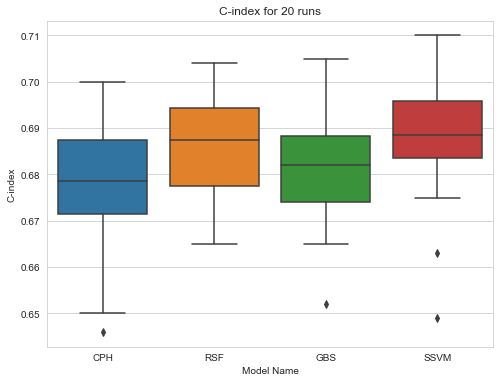

In [30]:
# 6.4 Visualise results
name = ['CPH', 'RSF', 'GBS', 'SSVM']
cv_res = []

for i in range(0,4):
    for c in c_index_list[i]:
        cv_res.append([name[i],c])

c_plot = pd.DataFrame(cv_res, columns=['Model Name','C-index'])

plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="Model Name", y="C-index", data=c_plot)
plt.title('C-index for 20 runs')
# plt.savefig('Plot\Exp1_cindex.pdf') 

(396, 27)

Model CPH


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          40.56 <0.005     32.29

(396, 27)

Model RSF


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          46.43 <0.005     36.62

(396, 27)

Model GBS


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          47.36 <0.005     37.30

(396, 27)

Model SSVM


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          39.70 <0.005     31.65

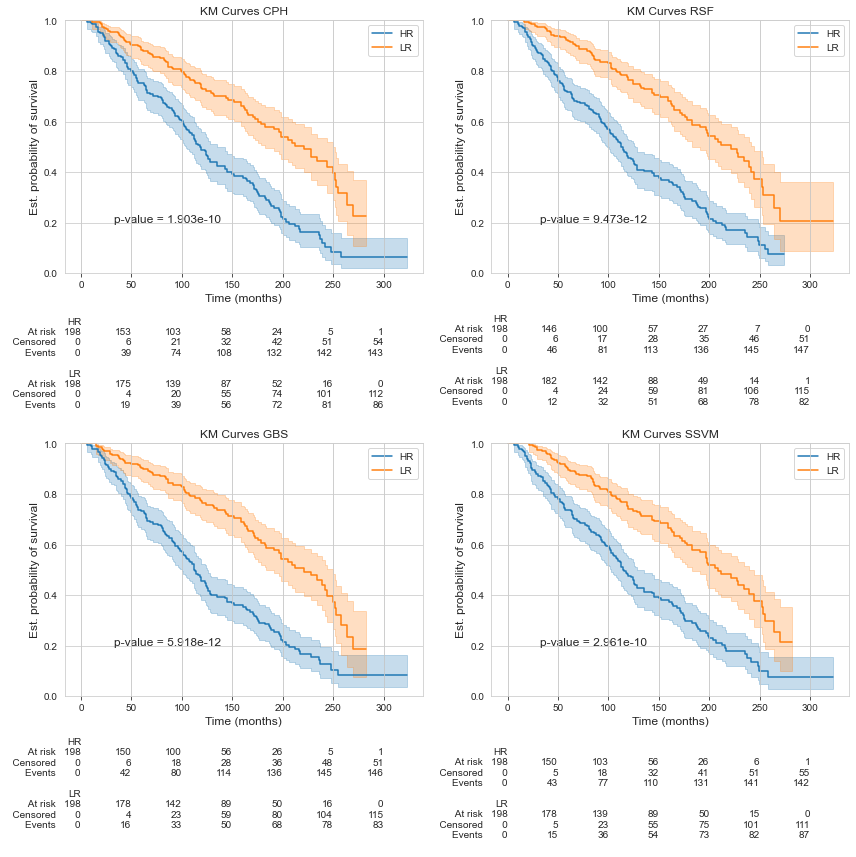

In [32]:
# KM Curve for median
fig, ax = plt.subplots(2,2,figsize=(12,12))
k  = 0
for pred in pred_list:
    df1 = X_test.reset_index(drop=True) 
    risk =[]
    
    y_pred = pred
    med = np.median(y_pred)
    r = np.where(y_pred >= med, 1, 0)

    df1['Risk'] = r
    print(df1.shape)
    ix = df1['Risk'] == 1

    df_y = pd.DataFrame(y_test)
    df_y['OS_STATUS'] = np.where(df_y['OS_STATUS'] == True, 1, 0)
    df1['OS_STATUS']= df_y['OS_STATUS']
    df1['OS_MONTHS']= df_y['OS_MONTHS']
    T_hr, E_hr = df1.loc[ix]['OS_MONTHS'], df1.loc[ix]['OS_STATUS']
    T_lr, E_lr = df1.loc[~ix]['OS_MONTHS'], df1.loc[~ix]['OS_STATUS']

    # Set-up plots
    k+=1
    plt.subplot(2,2,k)

    # Fit survival curves
    kmf_hr = KaplanMeierFitter()
    ax = kmf_hr.fit(T_hr, E_hr, label='HR').plot_survival_function()

    kmf_lr = KaplanMeierFitter()
    ax = kmf_lr.fit(T_lr, E_lr, label='LR').plot_survival_function()

    add_at_risk_counts(kmf_hr, kmf_lr)
    # Format graph
    plt.ylim(0,1)
    ax.set_xlabel('Time (months)',fontsize='large')
    ax.set_ylabel('Est. probability of survival',fontsize='large')

    # Calculate p-value
    res = logrank_test(T_hr, T_lr, event_observed_A=E_hr, event_observed_B=E_lr, alpha=.95)
    print('\nModel', name[k-1])
    res.print_summary()

    # Locate the label at the 1st out of 9 tick marks
    xloc = max(np.max(T_hr),np.max(T_lr)) / 10
    ax.text(xloc,.2,'p-value = {:0.3e}'.format(res.p_value),fontsize=12)
    ax.set_title('KM Curves {}' .format(name[k-1]))
    plt.tight_layout()
    plt.savefig('Plot\Exp1_KM.pdf') 


Model CPH


Permutation explainer: 397it [00:10,  1.07it/s]                         


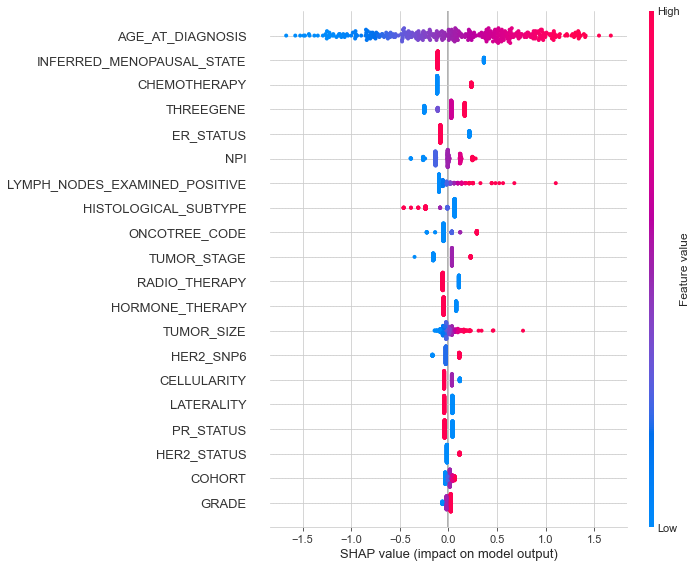


Model RSF


Permutation explainer:  45%|████▌     | 180/396 [4:05:49<4:56:37, 82.40s/it]
Permutation explainer: 397it [8:18:25, 75.52s/it]


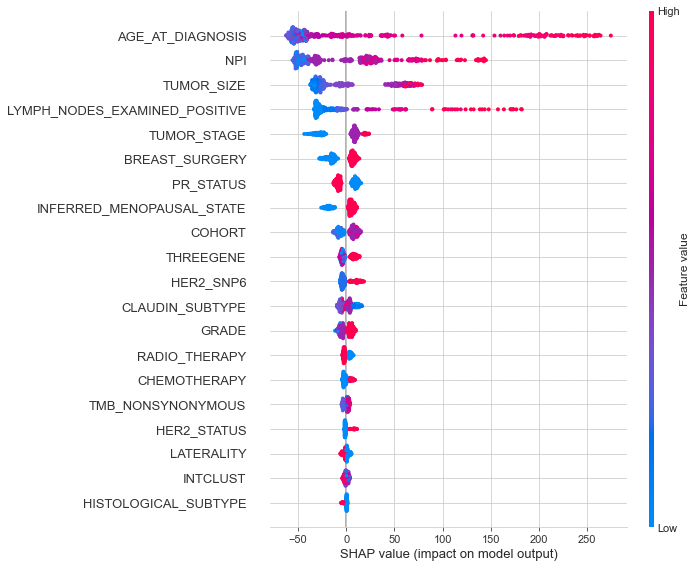


Model GBS


Permutation explainer: 397it [00:29,  8.88it/s]


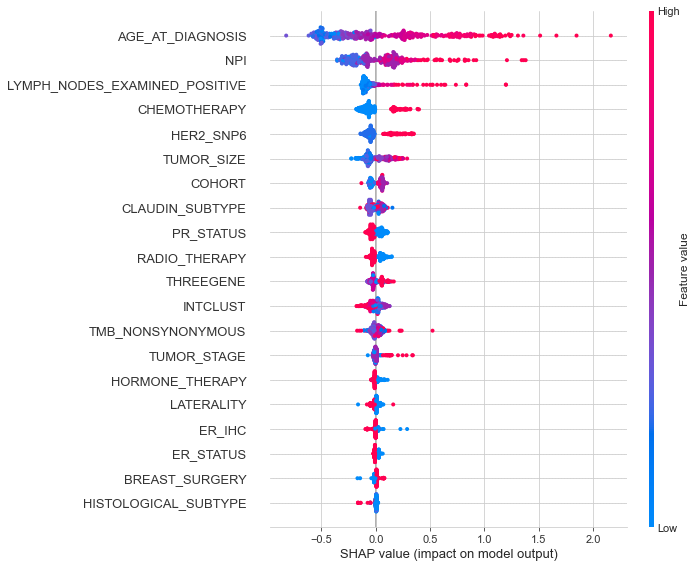


Model SSVM


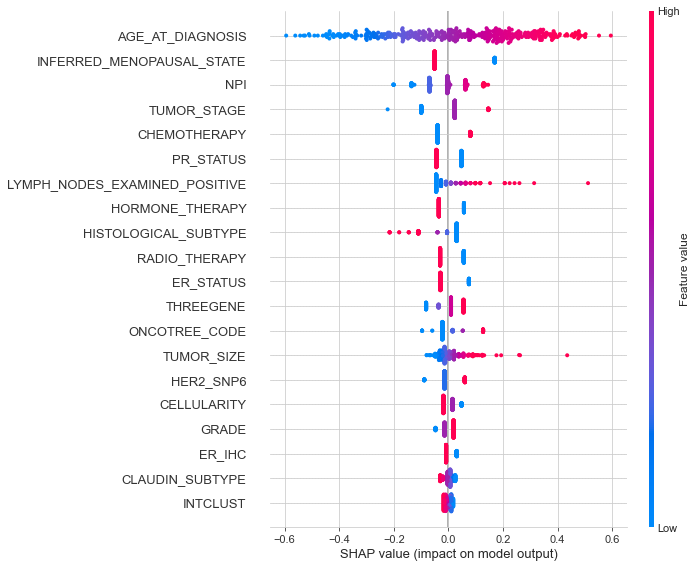

In [105]:
# Step 7: Interpret data
# Initialize JS For Plot
shap.initjs()

for i in range(0,4):
    print('\nModel', name[i])
    m = model_list[i][1]
    m.fit(X_train,y_train)
    explainer = shap.Explainer(m.predict, X_train, feature_names=X_train.columns)
    shaps = explainer(X_test)
    shap.summary_plot(shaps, X_test)